Used after running the One Dimensional Gaussain Fit notebook to get the gaussian params, and the Weibull_Distribution_Fit notebook to generate the parameters for the weibull fits.  This notebook then takes the parameters generated and calculates the odds ratio to find the perfered model. At the end, there is a period distance calculation to determine any relationship between that (distance to resonance) and the weibull parameters. 

In [1]:
import numpy as np
import pandas as pd
import time
import os
from scipy import stats
import matplotlib 
from matplotlib import pyplot as plt

In [2]:
weibull_info = pd.read_csv("../Figures/MCMCFigures/Weibull_MCMC_Params.csv", index_col = 0)
gaussian_info = pd.read_csv("../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences.csv", index_col = 0)
#wei_bull_probs = pd.read_csv("../Figures/MCMCFigures/Weibull_Probabilities.csv", index_col = 0)
#pd.concat([weibull_info, gaussian_info])
print weibull_info.shape
weibull_info.head()

(53, 9)


,ID,Probability,Gamma,Location,Alpha,Gamma_Error,Location_Error,Alpha_Error,Determinant
0,10518,1.050254e-02,0.548814,0.715189,0.602763,0.230689,0.303886,0.281796,0.000371
1,1174,9.109783e-36,0.417022,0.720324,0.000114,0.264467,0.301296,0.319326,0.000530
2,12073,2.004197e-02,0.435995,0.025926,0.549662,0.271411,0.290108,0.227940,0.000313
3,12840,8.587058e-03,0.550798,0.708148,0.290905,0.242771,0.224148,0.273904,0.000190
4,13362,2.077147e-01,0.967030,0.547232,0.972684,0.274328,0.320001,0.252004,0.000468


In [3]:
print gaussian_info.shape
gaussian_info.head(25)

(53, 7)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,10518,0.000087,6.466638,0.433123,0.013783,0.009675,1.774875e-08
1,1174,0.000126,5.257664,0.238005,0.007563,0.005341,1.632020e-09
2,12073,0.000070,4.522320,0.528029,0.016497,0.011818,3.799467e-08
3,12840,0.000048,4.705912,0.611499,0.019386,0.013400,6.748165e-08
4,13362,0.000082,2.080365,0.387756,0.011904,0.008776,1.091486e-08
5,15003,0.000098,6.748090,0.461451,0.014842,0.010386,2.371625e-08
6,15220,0.000089,5.811591,0.366231,0.011645,0.008312,9.356511e-09
7,16588,0.000073,6.629005,0.462531,0.014497,0.010406,2.275697e-08
8,17641,0.000078,5.446672,0.386554,0.012233,0.008563,1.096944e-08
9,18539,0.000090,6.815174,0.522620,0.016754,0.011586,3.767926e-08


In [4]:
#use uniform prior for everything
gamma_range = weibull_info["Gamma"].max() - weibull_info["Gamma"].min()
alpha_range = weibull_info["Alpha"].max() - weibull_info["Alpha"].min()
loc_range = weibull_info["Location"].max() -weibull_info["Location"].min()
sigma_range = gaussian_info["Sigma"].max() - gaussian_info["Sigma"].min()
mean_range = gaussian_info["Mean"].max() - gaussian_info["Mean"].min()
print gamma_range, loc_range, alpha_range, sigma_range, mean_range



0.97863735959 0.955007852949 0.999752917807 0.994386702192 5.57271793049


In [5]:
bayes_factor = np.zeros((gaussian_info.shape[0], 4))

for i in range(gaussian_info.shape[0]):
    #gaussian prop is pron, weibel prob is log prob
    gauss_factor = gaussian_info.loc[i]["Probability"] * (2.*np.pi)*gaussian_info.loc[i]["Determinant"]**0.5 *(1./sigma_range)*(1./mean_range)
    weibull_factor = weibull_info.loc[i]["Probability"] * (2.*np.pi)**(1.5)*weibull_info.loc[i]["Determinant"]**0.5 * (1./gamma_range) * (1./alpha_range)*(1./loc_range)
    
    #print gauss_factor, weibull_factor, weibull_factor/gauss_factor
    bayes_factor[i, :] = gaussian_info.loc[i]["ID"] , gauss_factor, weibull_factor, weibull_factor/gauss_factor
    print weibull_info.loc[i]["ID"],
    #break
bayes_factor_frame = pd.DataFrame(bayes_factor, columns=["ID", "Gauss_Factor", "Weibull_Factor", "Bayes_Factor"])

10518.0 1174.0 12073.0 12840.0 13362.0 15003.0 15220.0 16588.0 17641.0 18539.0 18651.0 19197.0 19591.0 19898.0 20041.0 2008.0 2010.0 20620.0 20972.0 2105.0 2128.0 21872.0 22032.0 22.0 22998.0 23005.0 23975.0 24008.0 24013.0 24017.0 24248.0 24346.0 24453.0 24576.0 24631.0 24705.0 24763.0 24824.0 24930.0 2612.0 3000.0 3898.0 42.0 4641.0 4753.0 5505.0 5958.0 67.0 7341.0 7431.0 8462.0 8582.0 8744.0


In [6]:
print len(np.unique(np.where(bayes_factor_frame == np.inf)[0]))
#bayes_factor_frame[  (bayes_factor_frame["Bayes_Factor"]<1) ]
print bayes_factor_frame["Bayes_Factor"].min(), bayes_factor_frame["Bayes_Factor"].max()
print np.logspace(-4, 8, 13)
print len(weibull_info)
weibull_info[bayes_factor_frame["Bayes_Factor"]>10000000]


2
0.0 6718821142.17
[  1.00000000e-04   1.00000000e-03   1.00000000e-02   1.00000000e-01
   1.00000000e+00   1.00000000e+01   1.00000000e+02   1.00000000e+03
   1.00000000e+04   1.00000000e+05   1.00000000e+06   1.00000000e+07
   1.00000000e+08]
53


,ID,Probability,Gamma,Location,Alpha,Gamma_Error,Location_Error,Alpha_Error,Determinant
22,22032,0.051697,0.208461,0.481681,0.420538,0.289119,0.273197,0.291855,0.000425
41,3898,0.014770,0.250924,0.046096,0.676816,0.252123,0.283160,0.221160,0.000205
51,8582,0.044059,0.675731,0.044712,0.343304,0.299309,0.205775,0.252201,0.000228


In [7]:
gaussian_info[bayes_factor_frame["Bayes_Factor"]>10000000]
#gaussian_info[gaussian_info["ID"]==2612]["Probability"]


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
22,22032,5.460150e-04,1.913805,0.056899,0.001820,0.001270,5.340215e-12
41,3898,8.517272e-08,5.448289,0.994400,0.024493,0.017271,1.788412e-07
51,8582,4.946970e-01,1.996377,0.000064,0.000002,0.000001,8.866040e-24


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


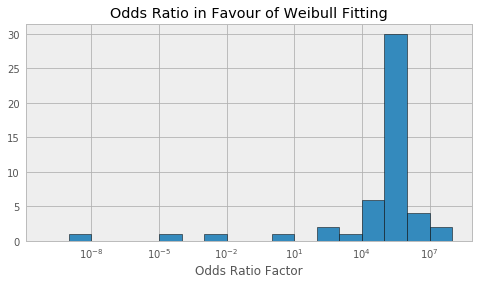

In [8]:
pd.options.display.mpl_style = 'default'
bayes_factor_frame.hist("Bayes_Factor", bins = np.logspace(-10, 8, 19), edgecolor = "black", figsize= (8,4))
plt.xscale("log")
plt.title("Odds Ratio in Favour of Weibull Fitting")
plt.xlabel("Odds Ratio Factor")
plt.savefig("../Figures/MCMCFigures/Bayes_Factor_Distribution.png")
plt.show()


In [9]:
#bayes_factor_frame
weibull_info[ (bayes_factor_frame["Bayes_Factor"]<1) ]

,ID,Probability,Gamma,Location,Alpha,Gamma_Error,Location_Error,Alpha_Error,Determinant
1,1174,9.109783e-36,0.417022,0.720324,0.000114,0.264467,0.301296,0.319326,0.000530
15,2008,3.317174e-11,0.848818,0.178896,0.054363,0.188376,0.285829,0.333179,0.000311
20,2128,1.577334e-01,0.588131,0.897714,0.891531,0.273517,0.244730,0.205499,0.000185
29,24017,1.451740e-16,0.863760,0.284906,0.073256,0.284182,0.281449,0.282624,0.000508
37,24824,3.346144e-10,0.944497,0.464098,0.192795,0.249271,0.338602,0.270323,0.000507
39,2612,8.966934e-02,0.546889,0.797899,0.820402,0.255359,0.232032,0.314846,0.000319


In [10]:
gaussian_info[ (bayes_factor_frame["Bayes_Factor"]<1) ]

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
1,1174,0.000126,5.257664,0.238005,0.007563,0.005341,1.632020e-09
15,2008,0.000535,2.746049,0.464412,0.016243,0.011352,3.399939e-08
20,2128,inf,2.228738,0.000034,inf,inf,inf
29,24017,0.000044,5.283116,0.631399,0.020144,0.014307,8.304516e-08
37,24824,0.000057,5.863755,0.672335,0.020828,0.014970,9.694569e-08
39,2612,inf,2.759919,0.000013,inf,inf,inf


In [15]:
#load _periods to see period distances
period_info = pd.read_csv("../csvs/initial_orbital_elements.csv", index_col =0 )
period_info.head()

,runstring,Stable,instability_time,Rel_Eerr,RHill12,RHill23,beta12,beta23,m1,a1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0000000.bin,0,1.235644e+07,1.099985e-04,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0000001.bin,0,1.348749e+05,1.388587e-08,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0000002.bin,0,1.276381e+04,3.048261e-04,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,0000003.bin,1,1.000000e+09,6.492574e-10,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0000004.bin,0,8.791888e+01,9.336734e-07,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392


In [17]:
subset = period_info.loc[gaussian_info["ID"].values]#load this data
subset.head()

,runstring,Stable,instability_time,Rel_Eerr,RHill12,RHill23,beta12,beta23,m1,a1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
10518,0010518.bin,0,9.271272e+06,4.160501e-07,0.013379,0.031345,17.739928,21.167394,6.041495e-06,1.0,...,1.606045,2.382316,0.000048,1.900831,2.620615,0.132402,5.200809,0.063746,2.934995,-2.231989
1174,0001174.bin,0,7.195121e+04,1.296026e-07,0.007554,0.022463,9.665713,4.538117,4.567549e-07,1.0,...,1.015623,1.683021,0.000027,1.174951,1.273573,0.005797,0.173265,0.018591,-1.385986,-0.354180
12073,0012073.bin,0,6.046899e+04,1.755339e-07,0.011665,0.016248,5.376848,20.374458,2.929657e-06,1.0,...,1.310894,3.498942,0.000009,1.393762,1.645432,0.000388,4.086019,0.003507,3.075035,0.348091
12840,0012840.bin,0,1.994020e+05,6.454656e-07,0.016699,0.021902,5.235766,29.839457,4.194588e-07,1.0,...,-2.618758,0.682436,0.000011,1.740973,2.297115,0.000209,4.157668,0.002687,2.008329,-2.500811
13362,0013362.bin,0,7.482249e+01,5.935752e-08,0.026588,0.012985,2.707432,18.330746,5.618518e-05,1.0,...,0.017113,-0.311131,0.000005,1.310015,1.499343,0.000659,-1.161714,0.032887,-0.309129,-1.374582


In [20]:
def period_func(vals, p_bls, p_inj):
    a, b = vals
    a = np.rint(a)
    b = np.rint(b)   
    return np.abs((a*p_bls - b*p_inj) / 0.5/(a*p_bls + b*p_inj))

In [73]:
from scipy.optimize import brute
rranges = (slice(1,6, 1), slice(1, 6, 1))
period_distances = np.zeros((subset.shape[0], 2))
for i in range(int(subset.shape[0])):
    #results = brute(period_func, ranges=rranges, args=(data_table["BLS_Period_1_0"][i], planet_periods[i]), full_output=True, finish= None)

    results = brute(period_func, ranges=rranges, args=(subset["P1"].values[i], subset["P2"].values[i]), full_output=True, finish= None)
    results2 = brute(period_func, ranges=rranges, args=(subset["P2"].values[i], subset["P3"].values[i]), full_output=True, finish= None)
    distance1 = period_func(results[0],subset["P1"].values[i], subset["P2"].values[i])
    distance2 = period_func(results2[0],subset["P2"].values[i], subset["P3"].values[i])
    #print distance1, distance2
    #print period_distances.shape
    #print period_distances[i, 0]
    #|print distance1
    print results[0], results2[0], subset[["P1", "P2", "P3"]].values[i]
    period_distances[i, 0] = distance1
    period_distances[i, 1] = distance2
    

[ 4.  3.] [ 2.  1.] [ 0.99999698  1.37636474  2.62061482]
[ 5.  5.] [ 5.  4.] [ 0.99999977  1.11149248  1.27357255]
[ 5.  5.] [ 3.  2.] [ 0.99999854  1.0955374   1.64543178]
[ 5.  4.] [ 2.  1.] [ 0.99999979  1.1339683   2.29711531]
[ 3.  3.] [ 4.  3.] [ 0.99997191  1.10986802  1.49934347]
[ 5.  4.] [ 4.  3.] [ 0.99999607  1.13610706  1.4698048 ]
[ 5.  3.] [ 5.  4.] [ 0.99996449  1.62300414  1.89791467]
[ 3.  2.] [ 5.  4.] [ 0.99996834  1.42039422  1.7086013 ]
[ 3.  3.] [ 5.  4.] [ 0.99999921  1.10617182  1.27948831]
[ 2.  1.] [ 5.  4.] [ 0.9999547   2.16726428  2.5734604 ]
[ 2.  1.] [ 2.  1.] [ 0.99999843  1.95964674  3.90716813]
[ 3.  3.] [ 5.  3.] [ 0.99999986  1.05144524  1.91874367]
[ 5.  4.] [ 3.  3.] [ 0.99999994  1.2230988   1.35404526]
[ 5.  3.] [ 5.  3.] [ 0.99999976  1.72296415  2.82430601]
[ 5.  3.] [ 5.  5.] [ 0.99999416  1.65982228  1.82752271]
[ 3.  3.] [ 3.  2.] [ 0.99997661  1.09663983  1.59068624]
[ 5.  4.] [ 5.  4.] [ 0.99999987  1.26750911  1.55320658]
[ 4.  3.] [ 5.

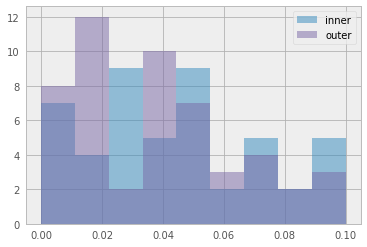

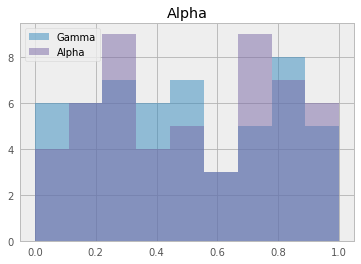

In [102]:
bins = np.linspace(0,0.1, 10)
plt.hist(period_distances[:,0], alpha = 0.5, label = "inner", bins = bins)
plt.hist(period_distances[:,1], alpha = 0.5, label = "outer", bins = bins)
plt.legend()

bins= np.linspace(0, 1 ,10)
fig = plt.figure()
ax  = fig.add_subplot("111")
weibull_info.hist("Gamma", ax= ax, alpha = 0.5, label = "Gamma", bins = bins)
weibull_info.hist("Alpha", ax= ax, alpha = 0.5, label = "Alpha", bins = bins)
plt.legend()

In [103]:
print 
sliced_section = weibull_info[(period_distances[:, 1]< 0.04)*(period_distances[:, 0]<0.04)]#.hist("Bayes_Factor")
sliced_section_bayes = bayes_factor_frame[(period_distances[:, 1]< 0.05)*(period_distances[:, 0]<0.05)]#.hist("Bayes_Factor")

sliced_section.head(10)

,ID,Probability,Gamma,Location,Alpha,Gamma_Error,Location_Error,Alpha_Error,Determinant
10,18651,1.588513e-03,0.771321,0.020752,0.633648,0.274607,0.260411,0.291824,0.000383
13,19898,1.397801e-02,0.777702,0.237541,0.824279,0.320171,0.265359,0.228865,0.000339
16,2010,1.520486e-02,0.223291,0.523163,0.550701,0.324555,0.238694,0.243583,0.000312
21,21872,3.647553e-03,0.048725,0.289110,0.720966,0.292603,0.255637,0.255059,0.000250
25,23005,7.648974e-07,0.870124,0.582277,0.278839,0.219183,0.215812,0.276023,0.000130
27,24008,2.980040e-02,0.425721,0.814584,0.735397,0.301553,0.274881,0.296206,0.000528
29,24017,1.451740e-16,0.863760,0.284906,0.073256,0.284182,0.281449,0.282624,0.000508
30,24248,1.113540e-02,0.644144,0.380748,0.663048,0.262028,0.271100,0.239380,0.000279
33,24576,1.578021e-02,0.248510,0.449975,0.410941,0.299831,0.292275,0.235324,0.000413
37,24824,3.346144e-10,0.944497,0.464098,0.192795,0.249271,0.338602,0.270323,0.000507


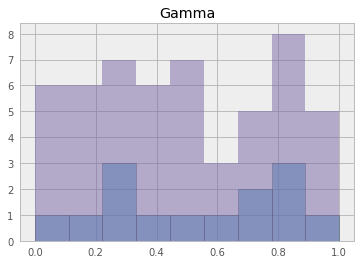

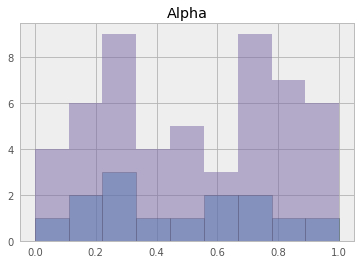

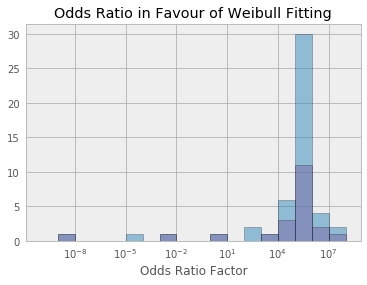

In [104]:
pd.options.display.mpl_style = 'default'
fig = plt.figure()
ax = fig.add_subplot("111")
bins = np.linspace(0,1,10)
sliced_section.hist("Gamma", edgecolor = "black",bins = bins, figsize= (8,4), ax = ax, alpha=0.5)
weibull_info.hist("Gamma", ax = ax, alpha =0.5, bins = bins)

plt.show()

pd.options.display.mpl_style = 'default'
fig = plt.figure()
ax = fig.add_subplot("111")


sliced_section.hist("Alpha", edgecolor = "black", bins = bins, figsize= (8,4), ax = ax, alpha=0.5)
weibull_info.hist("Alpha", ax = ax, alpha =0.5, bins = bins)

fig = plt.figure()
ax = fig.add_subplot("111")

bayes_factor_frame.hist("Bayes_Factor", ax = ax, bins = np.logspace(-10, 8, 19), edgecolor = "black", figsize= (8,4), alpha = 0.5)
sliced_section_bayes.hist("Bayes_Factor", ax = ax, bins = np.logspace(-10, 8, 19), edgecolor = "black", figsize= (8,4), alpha = 0.5)
plt.xscale("log")
plt.title("Odds Ratio in Favour of Weibull Fitting")
plt.xlabel("Odds Ratio Factor")
plt.show()



In [90]:
bayes_factor_frame[bayes_factor_frame["Bayes_Factor"]<=1]

,ID,Gauss_Factor,Weibull_Factor,Bayes_Factor
1,1174.0,5.774119e-09,3.535177e-36,6.122452e-28
15,2008.0,1.117792e-07,9.862403e-12,8.823111e-05
20,2128.0,inf,3.617183e-02,0.000000e+00
29,24017.0,1.428734e-08,5.516410e-17,3.861047e-09
37,24824.0,2.011058e-08,1.270267e-10,6.316412e-03
39,2612.0,inf,2.699398e-02,0.000000e+00
